# D(St)reams of Anomalies

Dalton Hahn (2762306)

## realAWSCloudWatch

https://github.com/numenta/NAB/tree/master/data/realAWSCloudwatch

## Goal

Perform feature engineering on the dataset and find a way to correlate items and extract useful features in order to perform anomaly detection upon the dataset.  Hopefully, by crafting meaningful features, anomaly detection can allow us greater insight into the dataset and assist us in diagnosing what is happening with the data.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statistics import mean, stdev

from scipy.stats import iqr

from sklearn.ensemble import IsolationForest

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


**NOTE** - Renamed many of the files to simpler names:
- ec2_cpu_utilization_5f5533 -> cpu_1
- ec2_cpu_utilization_24ae8d -> cpu_2
- ec2_cpu_utilization_53ea38 -> cpu_3
- ec2_cpu_utilization_77c1ca -> cpu_4
- ec2_cpu_utilization_825cc2 -> cpu_5
- ec2_cpu_utilization_ac20cd -> cpu_6
- ec2_cpu_utilization_c6585a -> cpu_7
- ec2_cpu_utilization_fe7f93 -> cpu_8
- ec2_disk_write_bytes_1ef3de -> disk_1
- ec2_disk_write_bytes_c0d644 -> disk_2
- ec2_network_in_5abac7 -> network_1
- ec2_network_in_257a54 -> network_2
- elb_request_count_8c0756 -> request
- grok_asg_anomaly -> grok
- iio_us-east-1_i-a2eb1cd9_NetworkIn -> iio
- rds_cpu_utilization_cc0c53 -> rds_1
- rds_cpu_utilization_e47b3b -> rds_2

## Read in the Data

In [2]:
df_cpu1 = pd.read_csv("../data/external/cpu_1.csv")
print(df_cpu1.shape)
df_cpu1.head()

(4032, 2)


,timestamp,value
0,2014-02-14 14:27:00,51.846
1,2014-02-14 14:32:00,44.508
2,2014-02-14 14:37:00,41.244
3,2014-02-14 14:42:00,48.568
4,2014-02-14 14:47:00,46.714


In [3]:
df_cpu2 = pd.read_csv("../data/external/cpu_2.csv")
print(df_cpu2.shape)
df_cpu2.head()

(4032, 2)


,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [4]:
df_cpu3 = pd.read_csv("../data/external/cpu_3.csv")
print(df_cpu3.shape)
df_cpu3.head()

(4032, 2)


,timestamp,value
0,2014-02-14 14:30:00,1.732
1,2014-02-14 14:35:00,1.732
2,2014-02-14 14:40:00,1.960
3,2014-02-14 14:45:00,1.732
4,2014-02-14 14:50:00,1.706


In [5]:
df_cpu4 = pd.read_csv("../data/external/cpu_4.csv")
print(df_cpu4.shape)
df_cpu4.head()

(4032, 2)


,timestamp,value
0,2014-04-02 14:25:00,0.068
1,2014-04-02 14:30:00,0.102
2,2014-04-02 14:35:00,0.100
3,2014-04-02 14:40:00,0.098
4,2014-04-02 14:45:00,0.102


In [6]:
df_cpu5 = pd.read_csv("../data/external/cpu_5.csv")
print(df_cpu5.shape)
df_cpu5.head()

(4032, 2)


,timestamp,value
0,2014-04-10 00:04:00,91.958
1,2014-04-10 00:09:00,94.798
2,2014-04-10 00:14:00,92.208
3,2014-04-10 00:19:00,93.722
4,2014-04-10 00:24:00,93.042


In [7]:
df_cpu6 = pd.read_csv("../data/external/cpu_6.csv")
print(df_cpu6.shape)
df_cpu6.head()

(4032, 2)


,timestamp,value
0,2014-04-02 14:29:00,42.652
1,2014-04-02 14:34:00,41.362
2,2014-04-02 14:39:00,43.408
3,2014-04-02 14:44:00,40.262
4,2014-04-02 14:49:00,40.328


In [8]:
df_cpu7 = pd.read_csv("../data/external/cpu_7.csv")
print(df_cpu7.shape)
df_cpu7.head()

(4032, 2)


,timestamp,value
0,2014-04-02 14:29:00,0.066
1,2014-04-02 14:34:00,0.066
2,2014-04-02 14:39:00,0.068
3,2014-04-02 14:44:00,0.134
4,2014-04-02 14:49:00,0.066


In [9]:
df_cpu8 = pd.read_csv("../data/external/cpu_8.csv")
print(df_cpu8.shape)
df_cpu8.head()

(4032, 2)


,timestamp,value
0,2014-02-14 14:27:00,2.296
1,2014-02-14 14:32:00,2.144
2,2014-02-14 14:37:00,2.274
3,2014-02-14 14:42:00,2.066
4,2014-02-14 14:47:00,2.350


### Notes
- Timestamps are not consistent throughout the various \*.csv files, therefore, not a good idea to attempt to combine all csv files into one dataframe
- Values reported in the CPU datasets have large variance.  Probably not a great idea to use some as train and some as test.
- Each \*.csv file has 4k rows, not a ton

## Simple Inter-quartile Statistics on datasets

In [10]:
def simple_stats(df):
    sorted(df['value'])
    q1, q3= np.percentile(df['value'],[25,75])
    inter_range = iqr(df['value'])
    lower_bound = q1 -(1.5 * inter_range) 
    upper_bound = q3 +(1.5 * inter_range) 
    print("IQR: ", inter_range)
    print("LOW: ", lower_bound)
    print("HIGH: ", upper_bound)
    print("Q1: ", q1)
    print("Q3: ", q3)
    
    counter = 0
    for row in df.iterrows():
        if row[1]['value'] > upper_bound or row[1]['value'] < lower_bound:
            #Uncomment for details on which rows were considered anomalous
            #print("ANOMALY: ", row[1]['timestamp'], " ", row[1]['value'])
            counter = counter + 1
            
    print("Total anomalies: ", counter)

In [11]:
simple_stats(df_cpu1)

IQR:  6.710000000000001
LOW:  29.230999999999998
HIGH:  56.071
Q1:  39.296
Q3:  46.006
Total anomalies:  4


In [12]:
simple_stats(df_cpu2)

IQR:  0.0020000000000000018
LOW:  0.129
HIGH:  0.137
Q1:  0.132
Q3:  0.134
Total anomalies:  1072


In [13]:
simple_stats(df_cpu3)

IQR:  0.10000000000000009
LOW:  1.6159999999999999
HIGH:  2.016
Q1:  1.766
Q3:  1.866
Total anomalies:  211


In [14]:
simple_stats(df_cpu4)

IQR:  0.00399999999999999
LOW:  0.09200000000000003
HIGH:  0.10799999999999998
Q1:  0.098
Q3:  0.102
Total anomalies:  1738


In [15]:
simple_stats(df_cpu5)

IQR:  5.218499999999992
LOW:  81.25325000000001
HIGH:  102.12724999999998
Q1:  89.081
Q3:  94.2995
Total anomalies:  137


In [16]:
simple_stats(df_cpu6)

IQR:  4.486999999999995
LOW:  26.41550000000001
HIGH:  44.36349999999999
Q1:  33.146
Q3:  37.632999999999996
Total anomalies:  672


In [17]:
simple_stats(df_cpu7)

IQR:  0.0020000000000000018
LOW:  0.063
HIGH:  0.07100000000000001
Q1:  0.066
Q3:  0.068
Total anomalies:  940


In [18]:
simple_stats(df_cpu8)

IQR:  1.2475
LOW:  0.30674999999999986
HIGH:  5.29675
Q1:  2.178
Q3:  3.4255
Total anomalies:  451


## Notes on IQR-based anomaly detection
- Very fast and easy to set up
- Anomaly detection seems very sporadic.  Some of the datasets reported nearly half of the datapoints as anomalous
- Others, like df_cpu1, where there is very little variation in the data performed very well at finding anomalies

# Visualizing Anomalies

In [19]:
def scatter_plot(df):
    fig,ax = plt.subplots(1)

    ax.scatter(df['timestamp'], df['value'], alpha=0.2)
    ax.set_xticklabels([])
    plt.show()

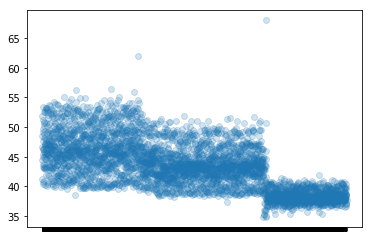

In [20]:
scatter_plot(df_cpu1)

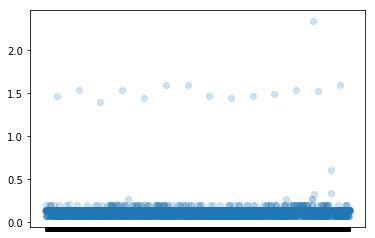

In [21]:
scatter_plot(df_cpu2)

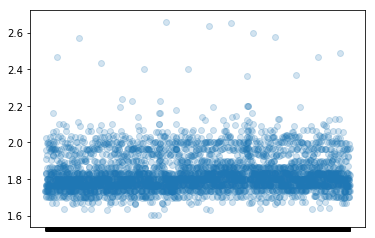

In [22]:
scatter_plot(df_cpu3)

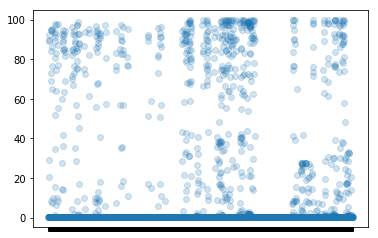

In [23]:
scatter_plot(df_cpu4)

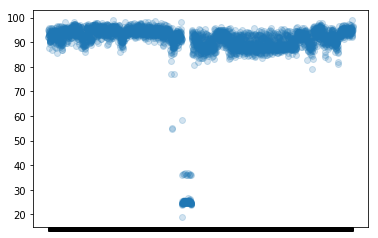

In [24]:
scatter_plot(df_cpu5)

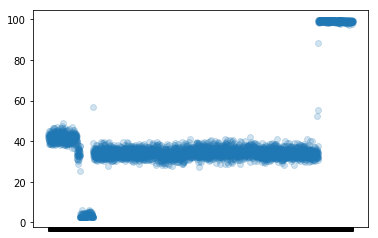

In [25]:
scatter_plot(df_cpu6)

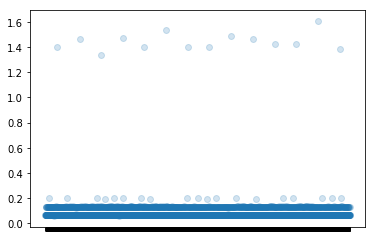

In [26]:
scatter_plot(df_cpu7)

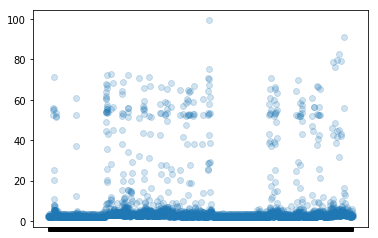

In [27]:
scatter_plot(df_cpu8)

### Based on the scatter plots, some datasets look much more difficult to run anomaly detection on than others.  Let's try and use Isolation Forest to do better detection.

# Isolation Forest

In [28]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html
# https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2
# https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1

def iso_forest(df):
    # fit the model
    clf = IsolationForest(n_estimators=1000, contamination=0.05)
    clf.fit(df['value'].values.reshape(-1,1))

    xx = np.linspace(df['value'].min(), df['value'].max(), len(df_cpu1)).reshape(-1,1)
    anomaly_score = clf.decision_function(xx)
    outlier = clf.predict(xx)

    df['anomaly'] = outlier
    outliers = df.loc[df['anomaly']==-1]
    outlier_index = list(outliers.index)

    #print(outlier_index)
    #Find the number of anomalies and normal points here points classified -1 are benign
    print("Benign, Anomalies\n", df['anomaly'].value_counts().values)


    plt.figure(figsize=(10,4))
    plt.plot(xx, anomaly_score, label='anomaly score')
    plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    plt.legend()
    plt.ylabel('anomaly score')
    plt.xlabel('Values')
    plt.show()

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Benign, Anomalies
 [2223 1809]


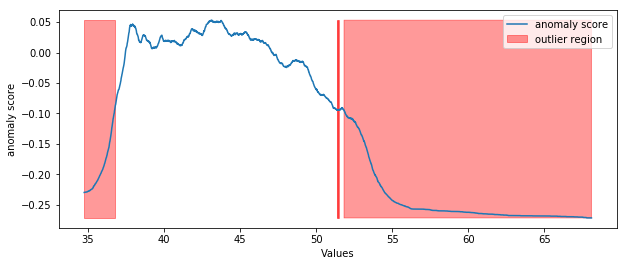

In [29]:
iso_forest(df_cpu1)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Benign, Anomalies
 [3904  128]


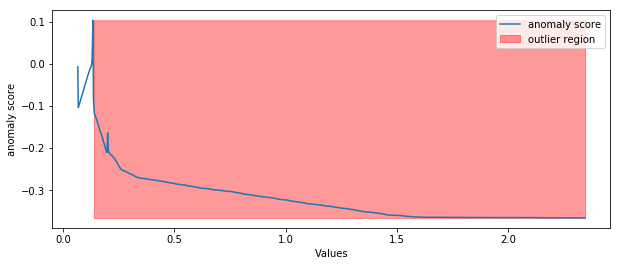

In [30]:
iso_forest(df_cpu2)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Benign, Anomalies
 [2727 1305]


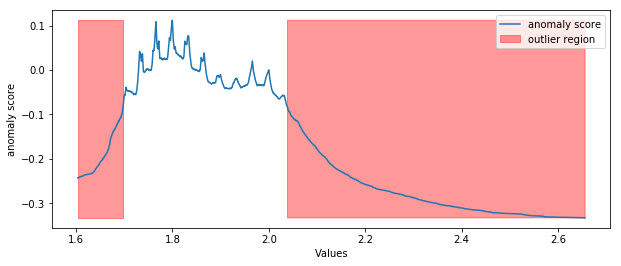

In [31]:
iso_forest(df_cpu3)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Benign, Anomalies
 [2038 1994]


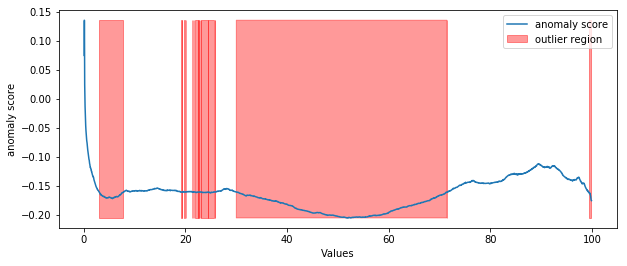

In [32]:
iso_forest(df_cpu4)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Benign, Anomalies
 [3400  632]


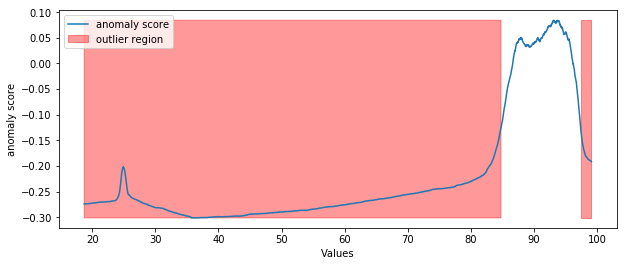

In [33]:
iso_forest(df_cpu5)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Benign, Anomalies
 [3253  779]


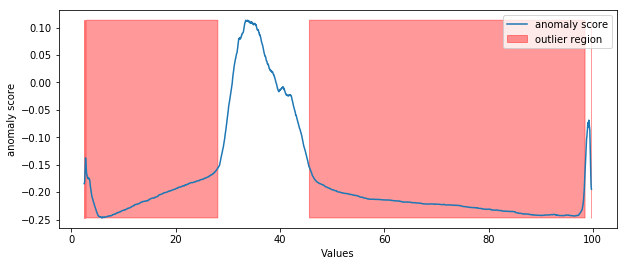

In [34]:
iso_forest(df_cpu6)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Benign, Anomalies
 [3842  190]


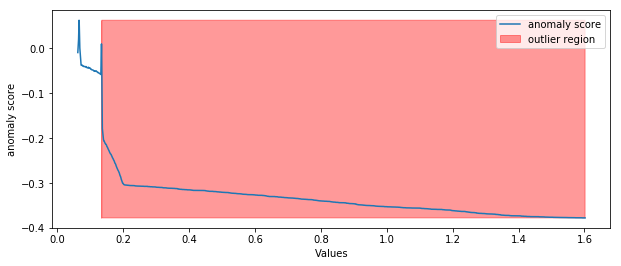

In [35]:
iso_forest(df_cpu7)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Benign, Anomalies
 [3472  560]


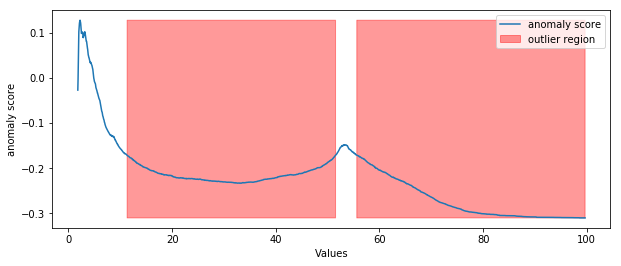

In [36]:
iso_forest(df_cpu8)

# Conclusions



- Comparing these anomaly graphs with the previous scatter plots, the trends are consistent
- Additional tuning necessary in order to more closely restrict the anomaly classification
- Difficult datasets to work with due to very large variance across the datapoints